# **Analyse comparative de modèles de machines learning pour du NLP et de la prédiction de séries temporelles afin de construire un algorithme de trading sur l'action AAPL**

Ce projet cherche à explorer des techniques avancées d'apprentissage automatique ainsi que des alternatives plus simples afin de :
- faire de l'analyse de sentiment sur des articles de presse en rapport avec la société Apple et son actualité
- faire de l'analyse de sentiment sur des posts récupérés sur Reddit également en rapport avec l'actualité de la société Apple
- prédire les variations du cours de l'action AAPL à travers de l'analyse de séries temporelles

En mélangeant l'analyse de sentiment et la prédiction des variations de l'action sur le marché, nous tenterons de construire un algorithme de trading innovant. 
Le projet comparera divers modèles prédictifs pour évaluer leur efficacité et leur fiabilité, et proposera une stratégie d'investissement automatisée basée sur les résultats obtenus.

Tout au long de ce projet, nous nous demanderons : **Quelle est l'efficacité relative des réseaux de neurones profonds par rapport aux méthodes d'apprentissage machine traditionnelles et à quel point leurs prédictions sont-elles assez satisfaisantes pour les intégrer à notre algorithme de trading ?**.

# Entraînement du modèle d'analyse de sentiments

Ici, nous entraînons un modèle d'analyse de sentiment de A à Z. Nous allons tester et comparer trois méthodes d'apprentissage :
- deux méthodes plutôt traditionnelles : la régression logistique et le Random Forest.
- des réseaux de neurones profonds particulièrement adaptés à ce genre de tâche : les Long Short-Term Memory ou LSTMs. 

On import les packages qui nous serons utiles par la suite et on code des fonctions auxquelles nous ferons appel à plusieurs reprises par la suite.

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import plotly.express as px
from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

def cleaning_text(text):
    #Passage du texte en miniscules
    text=text.lower()
    #Suppression des chiffres
    text=re.sub(r'\d+', '', text)
    #Suppression de la ponctuation et des symboles spéciaux
    text=re.sub(r'[^\w\s]', '', text)
    return text


def count_common_words(text):
    words=text.split()
    dict={}
    for el in words :
        if el not in dict:
            dict[el]=1
        else:
            dict[el]+=1
    return dict

def most_common_words(dictionary):
    sorted_dict=dict(sorted(dictionary.items(), key=lambda item: item[1], reverse=True))
    return sorted_dict



def combine_dictionaries(df,df_column_name):
    combined_dict={}
    column_index=df.columns.get_loc(str(df_column_name))
    for i in range(len(df)):
        temp_dictionary=df.iloc[i,int(column_index)]

        for key, value in temp_dictionary.items():
            if key not in combined_dict:
                combined_dict[key]=value
            else:
                combined_dict[key]+=value
    return combined_dict

stops = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def clean_stopwords(text):
    words = word_tokenize(text)
    cleaned_text=[word for word in words if word not in stops]
    return ' '.join(cleaned_text)

Nous allons entraîner notre modèle sur l'**International Movie Database** (IMDb) qui regroupe 50 000 critiques de films labellisées. Dans l'idéal, il aurait fallu utiliser un ensemble de reviews technologiques ou bien économiques mais n'ayant pas cela disposition, ni la possibilité de construire des ensembles d'entrainement de A à Z, nous allons utiliser ce dataset. Nous testerons ensuite ses performances sur les articles récupérés via une API et les posts Reddit.

In [92]:
df_imdb= pd.read_csv('/Users/dabadieraphael/Documents/GitHub/Python-pour-la-DS/IMDB Dataset.csv')
df_imdb

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


## Analyse préliminaire du dataset

In [93]:
sentiment_counts = df_imdb['sentiment'].value_counts()
fig = px.pie(values=sentiment_counts.values, names=sentiment_counts.index, title='Répartition des sentiments dans la base')
fig.show()

In [94]:
print(f"Il y a {len(df_imdb)} critiques répertoriées dans cette base de données, également réparties entre les classes 'positive' et 'negative'")

Il y a 50000 critiques répertoriées dans cette base de données, également réparties entre les classes 'positive' et 'negative'


Exhibons le **contenu** de l'une d'entre elles.

In [95]:
df_imdb.iloc[0,0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

Intéressons-nous à la **longueur** de ces critiques:

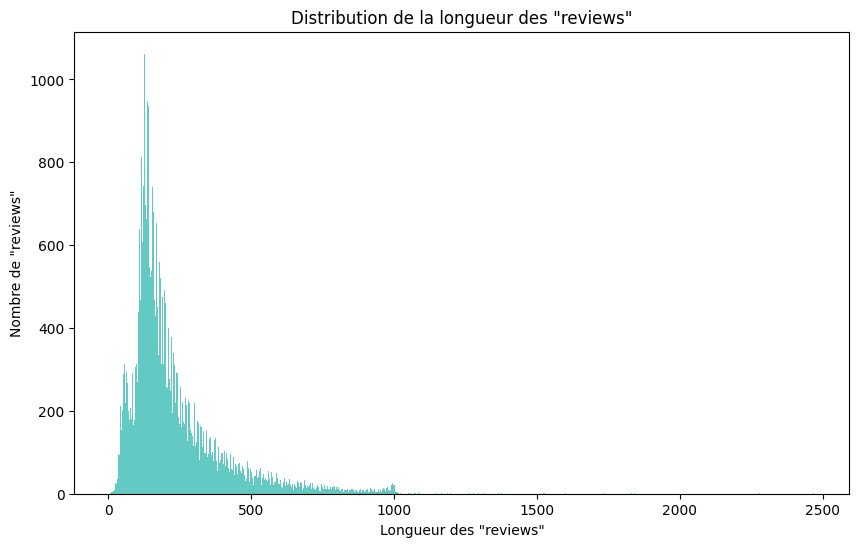

In [96]:
df_imdb['length']=df_imdb['review'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
plt.hist(df_imdb['length'], bins=1000, color='lightseagreen', alpha=0.7)
plt.title('Distribution de la longueur des "reviews"')
plt.xlabel('Longueur des "reviews"')
plt.ylabel('Nombre de "reviews"')
plt.show()

On remarque que la plupart des critiques ont une longueur comprise **entre 100 et 500 mots**. On constate également une "queue longue" qui indique que certaines critiques sont bien plus longues et peuvent atteindre jusqu'à 2500 mots.

In [97]:
df_imdb['length'].describe()

count    50000.000000
mean       231.156940
std        171.343997
min          4.000000
25%        126.000000
50%        173.000000
75%        280.000000
max       2470.000000
Name: length, dtype: float64

La méthode '**describe**' permet de rentrer plus en détails :
- la longueur moyenne de ces critiques est de 231 mots
- L'écart type de 171 mots suggère une variation importante dans la longueur des critiques
- 75% des critiques ont une longueur de moins de 280 mots
- la critique la plus longue contient 2470 mots

Intéressons-nous aux **mots les plus fréquents** dans ces critiques :

In [98]:
#On nettoie le texte en passant tout en minuscule et en supprimant les caractères inutiles

df_imdb['Content_cleaned']=df_imdb['review'].apply(cleaning_text)
df_imdb.head()

,review,sentiment,length,Content_cleaned
0,One of the other reviewers has mentioned that ...,positive,307,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,162,a wonderful little production br br the filmin...
2,I thought this was a wonderful way to spend ti...,positive,166,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,138,basically theres a family where a little boy j...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230,petter matteis love in the time of money is a ...


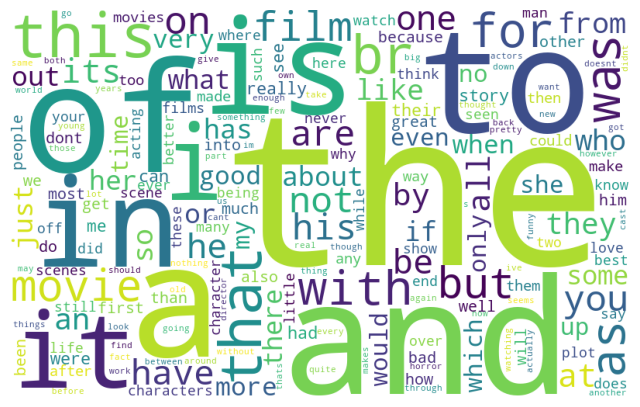

In [99]:
from wordcloud import WordCloud

#On réunit l'ensemble des critiques en un seul corpus.
text=' '.join(df_imdb['Content_cleaned'])
words=text.split()
word_counts=Counter(words)
wordcloud = WordCloud(width = 800, height = 500, background_color ='white').generate_from_frequencies(word_counts)


plt.figure(figsize = (8, 8)) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.show()


Les mots qui apparaissent le plus souvent sont sans surprise des **stopwords**. Nous les supprimons par la suite et affichons de nouveau un wordcloud sans eux.

In [100]:
df_imdb['Content_cleaned_from_stopwords']=df_imdb['Content_cleaned'].apply(clean_stopwords)
df_imdb.head()

,review,sentiment,length,Content_cleaned,Content_cleaned_from_stopwords
0,One of the other reviewers has mentioned that ...,positive,307,one of the other reviewers has mentioned that ...,one reviewers mentioned watching oz episode yo...
1,A wonderful little production. <br /><br />The...,positive,162,a wonderful little production br br the filmin...,wonderful little production br br filming tech...
2,I thought this was a wonderful way to spend ti...,positive,166,i thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,138,basically theres a family where a little boy j...,basically theres family little boy jake thinks...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230,petter matteis love in the time of money is a ...,petter matteis love time money visually stunni...


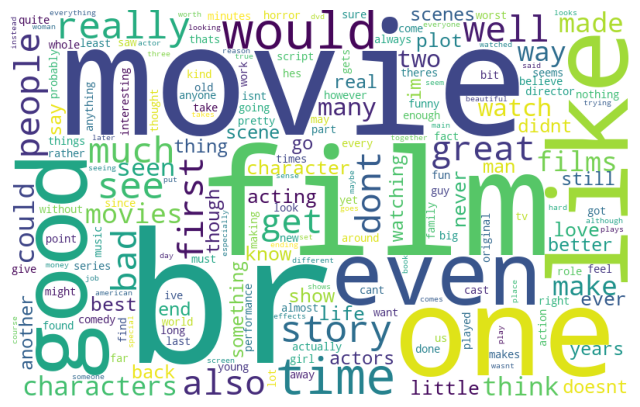

In [101]:
text=' '.join(df_imdb['Content_cleaned_from_stopwords'])
words=text.split()
word_counts=Counter(words)
wordcloud = WordCloud(width = 800, height = 500, background_color ='white').generate_from_frequencies(word_counts)


plt.figure(figsize = (8, 8)) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.show()

Les mots les plus fréquents sont plus intéressants. On remarque toutefois que "**br**" revient souvent alors que ce mot n'a pas de sens.

In [102]:
df_imdb.iloc[0,0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

On remarque que "br" apparaît au début des phrases. Ce caractère correspond à des retours à la ligne. Supprimons ce caractère par défaut. 

In [103]:
df_imdb['Content_cleaned_from_stopwords'] = df_imdb['Content_cleaned_from_stopwords'].str.replace('br', '')
df_imdb['Content_cleaned_from_stopwords'].loc[0]

'one reviewers mentioned watching oz episode youll hooked right exactly happened me  first thing struck oz utality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word  called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far away  would say main appeal show due fact goes shows wouldnt dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz doesnt mess around first episode ever saw struck nasty surreal couldnt say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards wholl sold nickel inmates wholl kill order get away well mannered middle class i

Rentrons dans une analyse descriptive plus poussée en **analysant les mots les plus fréquents** et en **explorant la corrélation entre longueur des critiques et sentiments exprimés**.

In [104]:
#Mots les plus fréquents

df_imdb['Counting_Words']=df_imdb['Content_cleaned_from_stopwords'].apply(count_common_words)
df_imdb['Most_common_words']=df_imdb['Counting_Words'].apply(most_common_words)
combined_dict=combine_dictionaries(df_imdb,'Most_common_words')

import plotly.express as px
from collections import Counter

sorted_text_dictionary=sorted(combined_dict.items(), key= lambda item:item[1], reverse=True)[:15]

keys=[key for key, value in sorted_text_dictionary]
values=[value for key, value in sorted_text_dictionary]


fig = px.bar(x=keys, y=values, title="Top 15 des mots les plus fréquents", labels={'x':'Mots', 'y':'Fréquences'}, color=values)
fig.show()

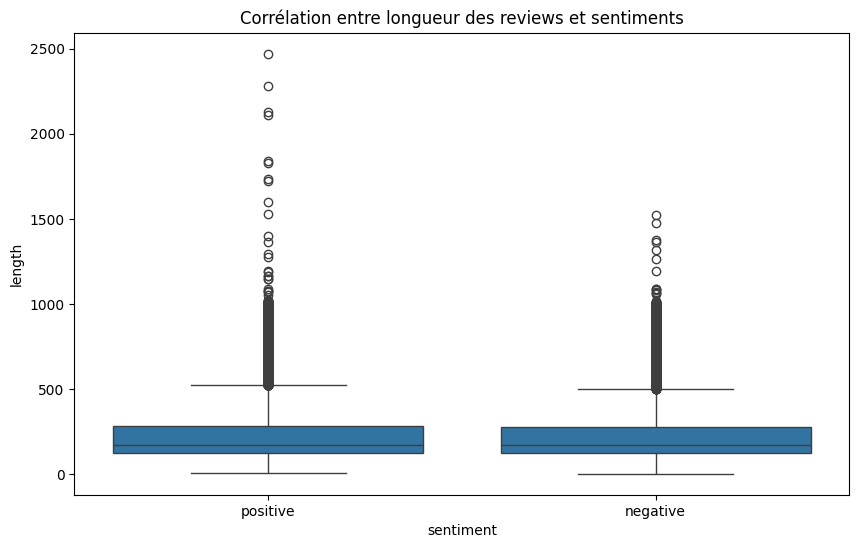

In [105]:
#Corrélation entre longueur et sentiment
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='length', data=df_imdb)
plt.title('Corrélation entre longueur des reviews et sentiments')
plt.show()

On remarque que :
- les **médianes** sont similaires entre les deux groupes comparés
- la **dispersion des données** représentée par la hauteur de chacune des boîtes est similaire
- il y a plus de valeurs aberrantes ou "**outliers**" dans la catégorie "positive" que "negative".

On en déduit qu'il n'y a pas de corrélation entre longueur de la critique et sentiment exprimé.

# Vectorisation des données

Afin de rendre le texte utilisable pour l'entrainement de modèles de ML, nous **vectorisons** son contenu. En effet, les modèles utilisés par la suite ne peuvent prendre en entrée que des caractères numériques. Nous convertissons donc les critiques dans un langage adapté.

On utilise, pour ce faire, la méthode **TF-IDF** (Term Frequency - Inverse Document Frequency). Elle permet de déterminer l'importance relative d'un mot dans un corpus. Elle associe à chaque terme du corpus un score. Ce score obtenu est la fréquence relative des termes d’un document par rapport à tous les autres documents qui contiennent également le mot-clé en question.

In [204]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer=TfidfVectorizer(max_features=2000)
X_reg= vectorizer.fit_transform(df_imdb['Content_cleaned_from_stopwords'])
X_reg

<50000x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 3245034 stored elements in Compressed Sparse Row format>

X_reg est une matrice **sparse** (ou creuse), c'est-à-dire qu'il y a beaucoup de valeurs nulles. Nous cherchons à n'afficher que les valeurs non nulles de cette matrice afin de mieux comprendre ce qu'elle contient.

In [107]:
rows, columns = X_reg.nonzero() #On extrait les valeurs non nulles de X_reg
compteur=0
for row, column in zip(rows, columns):
    print(f"(Row, Col): ({row}, {column}), valeur: {X_reg[row, column]}")
    compteur+=1
    if compteur==10:
        break

(Row, Col): (0, 1566), valeur: 0.08298917641771424
(Row, Col): (0, 1797), valeur: 0.10069902982844499
(Row, Col): (0, 157), valeur: 0.07860095207441886
(Row, Col): (0, 1090), valeur: 0.06452247491290831
(Row, Col): (0, 565), valeur: 0.08405671782286106
(Row, Col): (0, 1587), valeur: 0.1128587890145295
(Row, Col): (0, 1670), valeur: 0.09678527436456778
(Row, Col): (0, 964), valeur: 0.08497304581614817
(Row, Col): (0, 1823), valeur: 0.08727169436159503
(Row, Col): (0, 280), valeur: 0.09340413117026808


La sortie imprimée montre les indices de ligne (ie le document) et de colonne (ie le mot) dans la matrice TF-IDF où les valeurs sont non nulles, ainsi que les scores TF-IDF correspondants.  Des scores plus élevés suggèrent une plus grande importance du mot dans le contexte du document donné, inversement des scores faibles suggèrent une importance limitée du terme dans le contexte du document. Ces informations peuvent être utilisées pour comprendre les caractéristiques distinctives de chaque document dans le jeu de données en mettant en lumière les mots qui en font un texte unique.

Dernière étape avant la phase d'entraînement de la régression logistique, nous divisons notre ensemble de données en ensembles d'entraînement et de test. Le modèle sera entraîné sur le premier et tentera de généraliser sur le second.

In [205]:
from sklearn.model_selection import train_test_split
X_train_reg, X_test_reg, Y_train_reg, Y_test_reg=train_test_split(X_reg,df_imdb['sentiment'],test_size=0.3)

Essayons de trouver le modèle qui convient le mieux entre une simple régression logisitique, random forest et des réseaux LSTM. On essaiera d'obtenir le maximum de chacun de ces 3 modèles et on retiendra le modèle entraîné le plus performant.

Commençons avec la régression logistique, le modèle le plus **simple** des trois. La régression logistique est normalement **assez bien adaptée à des problèmes binaires**. 

# Régression logistique

On crée une instance de régression logistique et on entraîne notre modèle.

In [206]:
from sklearn.linear_model import LogisticRegression

logistic_regression=LogisticRegression()

#On entraîne le modèle sur l'ensemble d'entraînement extrait de l'IMDB Dataset.csv
logistic_regression.fit(X_train_reg, Y_train_reg)

LogisticRegression()

In [207]:
# Première évaluation de la performance du modèle

from sklearn.metrics import classification_report

Y_predicted_reg= logistic_regression.predict(X_test_reg)
print(classification_report(Y_test_reg, Y_predicted_reg ))

              precision    recall  f1-score   support

    negative       0.88      0.88      0.88      7428
    positive       0.88      0.89      0.88      7572

    accuracy                           0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     15000



Interprétation : 
- La **précision** (True positive / (True positive + False positive)) mesure l'exactitude du modèle. Ici elle est de 0,88 en moyenne. Dans le cas des reviews négatives, la précision est de 88%. Cela indique que parmi les reviews classées comme négatives par le modèle, 88% l'étaient vraiment.
- Le **recall** correspond au rapport True positive / (True positive + False negative). Par exemple si on prend le cas "positive", un recall de 89% indique que 89% des reviews correspondant à un sentiment positif ont été détectées.
- Le **F1 Score** est la moyenne harmonique entre la précision et le recall. Il est de 88% ici.

Ces résultats sont d'ores et déjà **assez satisfaisants**. Par ailleurs on remarque que le modèle performe de manière similaire pour les deux classes. 

Dans le but de chercher à améliorer les performances du modèle, notamment en analysant plus en détails les valeurs de TP, TN, FN, FP. Pour cela on affiche la **matrice de confusion**: 

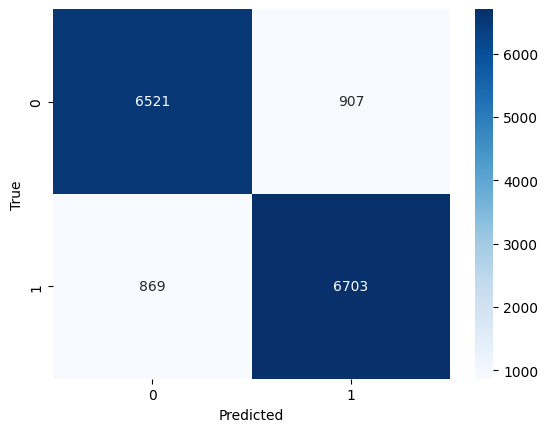

In [208]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(Y_test_reg, Y_predicted_reg)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Interprétation : 
- 6521 True positive
- 6703 True negative
- 907 False positive 
- 869 False negative


Pour améliorer un modèle de régression logistique, on peut notamment s'intéresser au **seuil de probabilité** utilisé pour décider de la classification. En ajustant ce seuil on peut notamment minimiser les faux positifs ou les faux négatifs. C'est notamment le cas lorsqu'on considère que se tromper dans un sens est plus coûteux que dans l'autre. Ici c'est le cas : nous voulons acheter que lorsque nous sommes sûrs que les articles récupérés en lien avec Apple sont positifs. Nous remarquons par ailleurs que le nombre de FP est supérieur au nombre de FN. Essayons de réduire les FP et voyons comment évolue la performance du modèle.

## Modification du seuil de probabilité

On fixe par exemple le nouveau seuil à **0.6**, ainsi pour que la prédiction soit considérée comme positive la probabilité devra être plus élevée qu'avant (0.6 > 0.5). 
Il sera ainsi plus difficile d'être classé positif, ce qui devrait réduire la quantité de FP (le modèle doit être plus confiant qu'avant pour pouvoir annoncer qu'une review est positive)

In [209]:
from sklearn.metrics import precision_recall_curve
import numpy as np

Y_probas= logistic_regression.predict_proba(X_test_reg)[:, 1] #probabilitées estimées par le modèle que chaque prédiction appartiene à la classe (des reviews) positive(s)
#On modifie désormais les prédictions précédentes pour obtenir la nouvelle classification
threshold=0.6
Y_predicted_reg_bis=np.where(Y_probas>=threshold,"positive", "negative")
print(classification_report(Y_test_reg, Y_predicted_reg_bis))

              precision    recall  f1-score   support

    negative       0.84      0.92      0.88      7428
    positive       0.91      0.83      0.87      7572

    accuracy                           0.87     15000
   macro avg       0.88      0.87      0.87     15000
weighted avg       0.88      0.87      0.87     15000



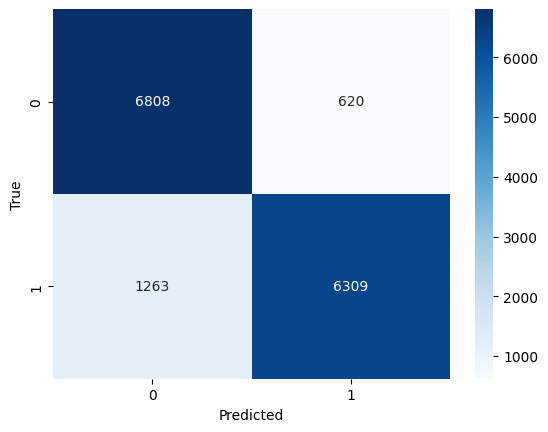

In [210]:
conf_mat = confusion_matrix(Y_test_reg, Y_predicted_reg_bis)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

On a bien fait diminuer le nombre de FP de 907 à 620 et augmenter la précision sur les reviews positives à 91%. Le recall et le F1 score moyens ont très légerement diminué pour passer à 0.87 sur l'ensemble du dataset. À première vue, une telle évolution reste plutôt positive pour nous : nous prendrons moins de risque lorsque nous inciterons les utilisateurs à acheter.

On peut aussi s'intéresser à un autre paramètre pour améliorer la précision : **le paramètre de régularisation**. Ici, en particulier, on s'intéresse à l'inverse de ce paramètre. Il permet de pénaliser les poids du modèle afin de réduire les risques d'overfitting.

Afin de déterminer la valeur optimale de C, on peut utiliser la validation croisée. L'idée avec la validation croisée est de s'assurer que la valeur de C n'est pas optimal pour un unique sous-ensemble spécifique mais bien généralisable à de nouvelles instances.

## Paramètre de régularisation

In [211]:
from sklearn.model_selection import GridSearchCV

logistic_regression_2=LogisticRegression(max_iter=1000) #Si on ne spécifie pas un nombre maximal d'itération, on obtient "STOP: TOTAL NO. of ITERATIONS REACHED LIMIT."
grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]} 
grid_search=GridSearchCV(logistic_regression_2, grid)
grid_search.fit(X_train_reg, Y_train_reg)
print(grid_search.best_params_)

{'C': 1}


On a obtenu C=1, on peut essayer d'affiner la valeur de C en changeant la grille de paramètres.

In [212]:
logistic_regression_2=LogisticRegression(max_iter=1000) #Si on ne spécifie pas un nombre maximal d'itération, on obtient "STOP: TOTAL NO. of ITERATIONS REACHED LIMIT."
grid={'C': [0.5, 0.75, 1, 1.25, 1.5, 2]} 
grid_search=GridSearchCV(logistic_regression_2, grid)
grid_search.fit(X_train_reg, Y_train_reg)
print(grid_search.best_params_)

{'C': 2}


On continue à affiner en modifiant à nouveau la grille.

In [213]:
logistic_regression_2=LogisticRegression(max_iter=1000) #Si on ne spécifie pas un nombre maximal d'itération, on obtient "STOP: TOTAL NO. of ITERATIONS REACHED LIMIT."
grid={'C': [2, 3, 4, 5, 6]} 
grid_search=GridSearchCV(logistic_regression_2, grid)
grid_search.fit(X_train_reg, Y_train_reg)
print(grid_search.best_params_)

{'C': 2}


On essaie d'affiner à nouveau la valeur de C en réduisant l'intervalle de recherche.

In [214]:
logistic_regression_2=LogisticRegression(max_iter=1000) #Si on ne spécifie pas un nombre maximal d'itération, on obtient "STOP: TOTAL NO. of ITERATIONS REACHED LIMIT."
grid={'C': np.linspace(2, 3, num=20)} #20 valeurs aléatoires entre 2 et 3
grid_search=GridSearchCV(logistic_regression_2, grid)
grid_search.fit(X_train_reg, Y_train_reg)
print(grid_search.best_params_)

{'C': 2.0526315789473686}


On évalue désormais le modèle en prenant C=2.05 et le seuil de 0.6.

In [215]:
logistic_regression_final=LogisticRegression(C=2.05) #On spécifie la valeur de C
logistic_regression_final.fit(X_train_reg, Y_train_reg)

Y_probas= logistic_regression_final.predict_proba(X_test_reg)[:, 1] #probas estimées par le modèle que chaque prédiction appartiene à la classe (des reviews) positive(s)
threshold=0.6
Y_predicted_bis=np.where(Y_probas>=threshold,"positive", "negative")
Y_predicted_bis
print(classification_report(Y_test_reg, Y_predicted_reg_bis))

              precision    recall  f1-score   support

    negative       0.84      0.92      0.88      7428
    positive       0.91      0.83      0.87      7572

    accuracy                           0.87     15000
   macro avg       0.88      0.87      0.87     15000
weighted avg       0.88      0.87      0.87     15000



On remarque qu'on obtient les mêmes résultats qu'avec C=2, cela est sûrement dû au fait que 2.05 est très proche de 2 et que le changement de valeur est trop faible pour observer de quelconques changements.
Les résultats obtenus avec ce modèle simple sont très satisfaisants. Essayons de voir si nous pouvons faire mieux avec l'un des deux modèles suivants.

# Random Forest

Les modèles de Random Forest sont plus robustes que les modèles de régression logistique. Ils permettent de capturer des relations non linéaires ce qui peut s'avérer fort utile pour de l'analyse de texte. Par ailleurs, ce sont des modèles qui nécessitent peu de fine tuning.

In [216]:
from sklearn.ensemble import RandomForestClassifier
random_forest= RandomForestClassifier(n_estimators=100) #On renseigne le nombre d'arbres. En ajoutant des arbres, on réduit le risque d'overfitting. On prend généralement entre 100 et 200 pour commencer.

X_train_rf, Y_train_rf, X_test_rf, Y_test_rf= X_train_reg, Y_train_reg, X_test_reg, Y_test_reg
random_forest.fit(X_train_rf, Y_train_rf)
Y_predicted_rf=random_forest.predict(X_test_rf)

print(classification_report(Y_test_rf, Y_predicted_rf))

              precision    recall  f1-score   support

    negative       0.84      0.87      0.85      7428
    positive       0.87      0.83      0.85      7572

    accuracy                           0.85     15000
   macro avg       0.85      0.85      0.85     15000
weighted avg       0.85      0.85      0.85     15000



On remarque des résultats à première vue moins satisfaisants que ceux obtenus avec la régression logistique avant fine-tuning avec une précision moyenne de 0.85.

In [217]:
print(confusion_matrix(Y_test_rf, Y_predicted_rf))

[[6449  979]
 [1272 6300]]


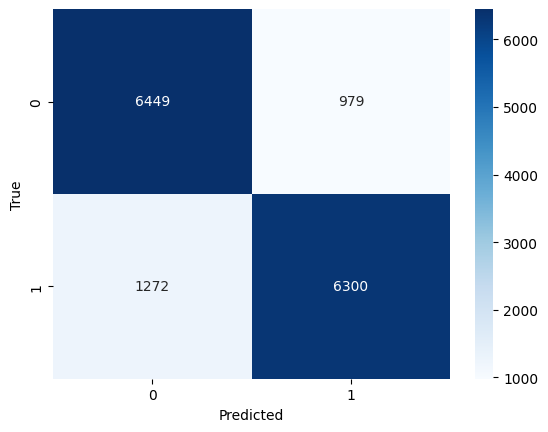

In [218]:
conf_mat = confusion_matrix(Y_test_rf, Y_predicted_rf)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [219]:
random_forest= RandomForestClassifier(n_estimators=50) #On renseigne le nombre d'arbres. En ajoutant des arbres, on réduit le risque d'overfitting. On prend généralement entre 50 et 200 pour commencer.

random_forest.fit(X_train_rf, Y_train_rf)
Y_predicted_rf_2=random_forest.predict(X_test_rf)

print(classification_report(Y_test_rf, Y_predicted_rf))

              precision    recall  f1-score   support

    negative       0.84      0.87      0.85      7428
    positive       0.87      0.83      0.85      7572

    accuracy                           0.85     15000
   macro avg       0.85      0.85      0.85     15000
weighted avg       0.85      0.85      0.85     15000



In [220]:
random_forest= RandomForestClassifier(n_estimators=200) 

random_forest.fit(X_train_rf, Y_train_rf)
Y_predicted_rf_2=random_forest.predict(X_test_rf)

print(classification_report(Y_test_rf, Y_predicted_rf_2))

              precision    recall  f1-score   support

    negative       0.84      0.86      0.85      7428
    positive       0.86      0.84      0.85      7572

    accuracy                           0.85     15000
   macro avg       0.85      0.85      0.85     15000
weighted avg       0.85      0.85      0.85     15000



On constate que diminuer de moitié le nombre d'arbres n'a entraîné aucun changement sur les métriques de performance. Multiplier par deux le nombre d'arbres initial a même déterioré les performances. Cela veut sûrement dire que 50 arbres est un nombre suffisant pour capturer les relations entre les données. L'augmentation des performances peut sûrement se faire en fine-tunant les autres paramètres.

Les hyperparamètres les plus importants dans le fine tuning sont 
- "n_estimators" :le nombre d'arbres dans la forêt
- "max_features" : le nombre de features prises en compte à chaque scission
- "max_depth" : la profondeur maximale de l'arbre
- "min_samples_split" : nombre minimum d'échantillon pour scinder un noeud

Essayons donc de fine-tuner ces paramètres afin de gagner en précision. GridSearchCV peut prendre du temps à tourner. Essayons de visualiser l'évolution des performances du modèle lorsqu'un seul paramètre varie.

In [221]:
#Visualisons les performances du modèle lorsque nous faisons varier "n_estimators"

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import time

n_trees_grid=[10, 50, 100, 200, 400]

# On va récupérer les valeurs de précision du modèle ainsi que les temps d'exécution lorsque n_estimators prend les valeurs présentes dans cette grille

training_precisions = []
test_precisions = []
training_times = []

for n in n_trees_grid:
    rf=RandomForestClassifier(n_estimators=n)

    start_time=time.time()
    rf.fit(X_train_rf, Y_train_rf)
    end_time=time.time()

    duration = end_time-start_time

    training_predictions=rf.predict(X_train_rf)
    test_predictions=rf.predict(X_test_rf)

    #Comparaison des prédictions aux vraies valeurs
    training_precision=accuracy_score(Y_train_rf, training_predictions)
    test_precision=accuracy_score(Y_test_rf, test_predictions)

    #On ajoute ces résultats aux listes initiales
    training_precisions.append(training_precision)
    test_precisions.append(test_precision)
    training_times.append(duration)


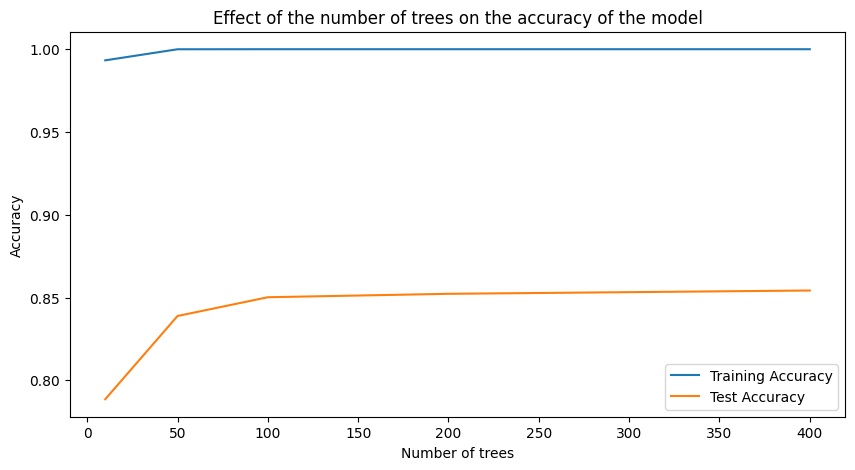

In [222]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.plot(n_trees_grid, training_precisions, label='Training Accuracy')
plt.plot(n_trees_grid, test_precisions, label='Test Accuracy')
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.title('Effect of the number of trees on the accuracy of the model')
plt.legend()
plt.show()

In [223]:
training_precisions

[0.9932857142857143, 0.9999714285714286, 1.0, 1.0, 1.0]

Text(0.5, 1.0, 'Training time VS number of trees')

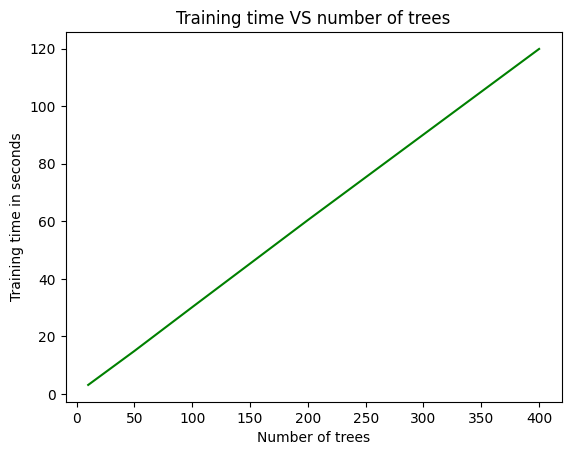

In [224]:
#On s'intéresse l'impact de l'augmentation du nombre d'arbres sur le temps d'entraînement du modèle

plt.plot(n_trees_grid, training_times, color='green')
plt.xlabel('Number of trees')
plt.ylabel('Training time in seconds')
plt.title('Training time VS number of trees')

Le premier graphique est une indication d'overfitting du modèle qui sur-performe sur l'ensemble d'entraînement atteignant une précision aberrante de 100%. Pour remédier à cela, on peut essayer de réduire la complexité du modèle.

Par défaut, 
- max_depth = None : les noeuds sont développés jusqu'à ce que toutes les feuilles soient pures ou contiennent moins que min_samples_split échantillons. On peut le fixer à des valeurs comme 10 ou 20
- min_samples_split = 2 : on peut passer cette valeur à 5 ou 1O.

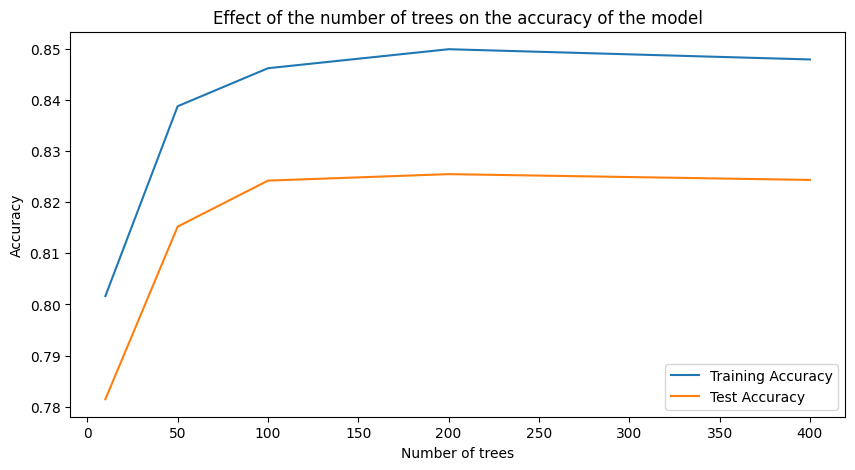

In [225]:
training_precisions_bis = []
test_precisions_bis = []
training_times_bis = []

for n in n_trees_grid:
    rf=RandomForestClassifier(n_estimators=n, max_depth=10, min_samples_split=5 )

    start_time=time.time()
    rf.fit(X_train_rf, Y_train_rf)
    end_time=time.time()

    duration = end_time-start_time

    training_predictions=rf.predict(X_train_rf)
    test_predictions=rf.predict(X_test_rf)

    #Comparaison des prédictions aux vraies valeurs
    training_precision=accuracy_score(Y_train_rf, training_predictions)
    test_precision=accuracy_score(Y_test_rf, test_predictions)

    #On ajoute ces résultats aux listes initiales
    training_precisions_bis.append(training_precision)
    test_precisions_bis.append(test_precision)
    training_times_bis.append(duration)

plt.figure(figsize=(10, 5))

plt.plot(n_trees_grid, training_precisions_bis, label='Training Accuracy')
plt.plot(n_trees_grid, test_precisions_bis, label='Test Accuracy')
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.title('Effect of the number of trees on the accuracy of the model')
plt.legend()
plt.show()

Ces résultats sont cohérents, nous avons rendu le modèle **moins complexe** donc il colle moins au données de l'ensemble d'entraînement. Par la même occasion, il **perd légèrement en précision** sur la base de test.

Essayons d'augmenter le paramètre max_depth pour ré-augmenter un peu la complexité du modèle afin de gagner en précision sur l'ensemble de test.

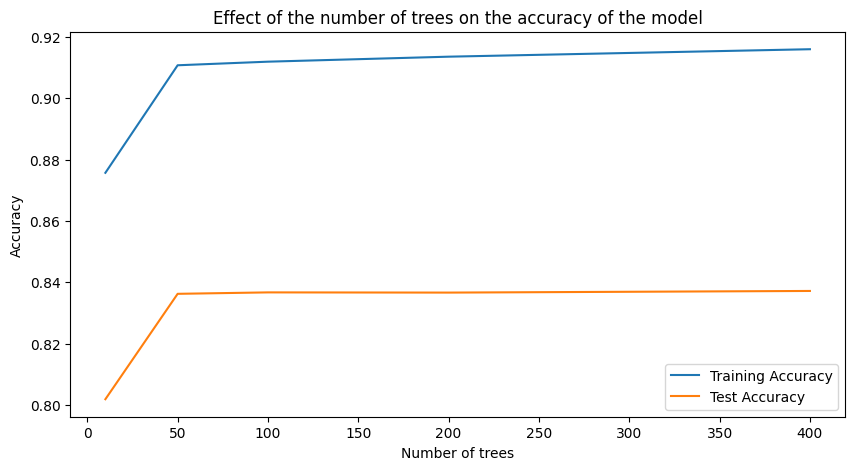

In [226]:
training_precisions_bis = []
test_precisions_bis = []
training_times_bis = []

for n in n_trees_grid:
    rf=RandomForestClassifier(n_estimators=n, max_depth=20, min_samples_split=5 )

    start_time=time.time()
    rf.fit(X_train_rf, Y_train_rf)
    end_time=time.time()

    duration = end_time-start_time

    training_predictions=rf.predict(X_train_rf)
    test_predictions=rf.predict(X_test_rf)

    #Comparaison des prédictions aux vraies valeurs
    training_precision=accuracy_score(Y_train_rf, training_predictions)
    test_precision=accuracy_score(Y_test_rf, test_predictions)

    #On ajoute ces résultats aux listes initiales
    training_precisions_bis.append(training_precision)
    test_precisions_bis.append(test_precision)
    training_times_bis.append(duration)

plt.figure(figsize=(10, 5))

plt.plot(n_trees_grid, training_precisions_bis, label='Training Accuracy')
plt.plot(n_trees_grid, test_precisions_bis, label='Test Accuracy')
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.title('Effect of the number of trees on the accuracy of the model')
plt.legend()
plt.show()

On a gagné un point de précision sur l'ensemble de validation en passant à près de 84% par rapport aux 83% obtenus précédemment, témoignant ainsi du fait que l'augmentation du paramètre "max_depth" a bien permis au modèle de gagner en complexité.

Afin d'améliorer la précision du modèle, on aurait pu augmenter la taille des données puisqu'un jeu de données plus grand bénéficie souvent à des modèles de Random Forest. Par choix, comme le modèle de régression logistique fournit des résultats plus satisfisants et que nous allons tester des réseaux de neurones complexes (LSTMs) dans la suite, nous en restons là pour le modèle de Random Forest.

# Long Short-Term Memory

Les LSTMs requièrent une phase de pré-traitement du texte bien plus importante. Conçus pour travailler avec des séquences de données, ils sont une évolution des Réseaux de Neurones Récurrents (RNN) et permettent notamment d'éviter les problèmes de vanishing gradient. Ils prennent en compte les dépendances séquentielles dans les données, ce qui les rend particulièrement performants pour prédire des séquences de mots ou assimiler des dépendances complexes dans les inputs comme nous pourrons l'exploiter aussi dans la partie de prévision du cours de l'action d'Apple. Ces caractéristiques nécessitent :

- la numérisation du texte (tokenisation)
- la normalisation des séquences de données de sorte à leur donner une longueur fixe (padding)
- l'odre séquentiel des features

## Tokenisation 

La tokenisation consiste à décomposer le texte en tokens. Ces derniers sont des nombres qui peuvent correspondre aussi bien à des mots qu'à des phrases ou même des caractères. C'est la première étape vers la conversion de données textuelles non structurées en un format ordonné et analysable par un modèle LSTM.

In [130]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [131]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#On définit le nombre maximal de mot pris en compte ci-dessous. De manière générale, 10000 mots est largement suffisant pour récupérer les mots les plus fréquents d'un langage.
#Les autres mots, moins importants (s'il y en a), ne seront pas pris en compte.

n_words=10000
tokenizer=Tokenizer(num_words=n_words)

#On construit désormais le dictionnaire interne à notre travail en se basant sur les 10000 mots considérés.
#La méthode fit_on_texts permet ici de donner un indice numérique unique à chacun d'entre eux

tokenizer.fit_on_texts(df_imdb['review'])

Pour plus de clarté, on peut visualiser le contenu de notre "dictionnaire" :

In [132]:
#Accédons à chaque mot unique 
word_index = tokenizer.word_index
df=pd.DataFrame({'Mot':word_index.keys()}, index=word_index.values())
df[:10]
    

,Mot
1,the
2,and
3,a
4,of
5,to
6,is
7,br
8,in
9,it
10,i


À chaque token du texte est associé un indice. Affichons les 15 mots les plus fréquents de notre corpus :

Text(0.5, 1.0, '15 most frequent words')

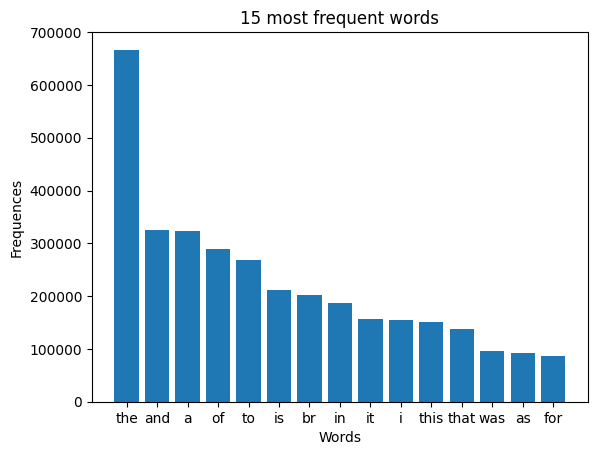

In [133]:
word_counts=tokenizer.word_counts
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:15]

list_of_words=[]
list_of_frequences=[]
for word, frequence in sorted_word_counts:
    for i in range(10):
        list_of_words.append(word)
        list_of_frequences.append(frequence)

fig, ax = plt.subplots()
ax.bar(list_of_words, list_of_frequences)

ax.set_ylabel('Frequences')
ax.set_xlabel('Words')
ax.set_title('15 most frequent words')

Ce n'est pas une surprise, on retrouve des stopwords.

In [134]:
print(f'Il y a {len(df)} tokens uniques dans notre vocabulaire.')

Il y a 124252 tokens uniques dans notre vocabulaire.


On remarque ici qu'il y a plus de tokens que la limite que nous avions spécifié pour n_words. À l'étape suivante, en appliquant la méthode texts_to_sequences, seuls les mots dont l'indice est inférieur à n_words seront gardés.

In [135]:
sequences = tokenizer.texts_to_sequences(df_imdb['review'])
#sequences est une liste de liste : chaque review de IMDB est transformé en liste, à chaque mot on associe l'indice correspondant dans word_index
print(df_imdb.iloc[0,0])
print(sequences[0])

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fac

## Padding 

Comme expliqué précédemment, nous devons fixer une longueur type pour chaque séquence créée afin qu'elles soient toutes de même taille.

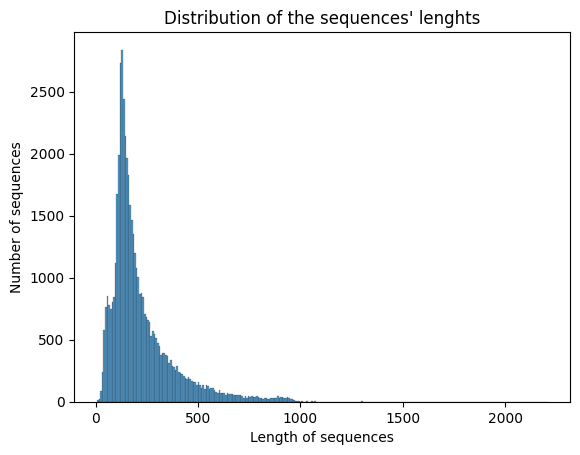

In [136]:
#On prend par exemple la longueur de la séquence la plus longue dans la liste de listes "sequences"
max_len=max(len(sequence) for sequence in sequences)

sequence_lengths = [len(seq) for seq in sequences]
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(sequence_lengths)
plt.xlabel('Length of sequences')
plt.ylabel('Number of sequences')
plt.title("Distribution of the sequences' lenghts")
plt.show()

On remarque que la plupart des sequences ont une longueur comprise entre 100 et 500 avec une queue longue vers la droite qui indique que certaines séquences atteignent les 2000 indices.

Les séquences de taille plus courte que max_len seront artificiellement rallongées en ajoutant des 0 comme on peut le voir ci-dessous.

In [137]:
padded_sequences = pad_sequences(sequences, maxlen=max_len)
print(padded_sequences[0])

[   0    0    0 ...  125 4103  486]


## Construction du modèle LSTM

In [138]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

#On choisit des paramètres initiaux et assez courants. On pourra procéder à une phase de fine-tuning ensuite.

dim_embedding=128
lstm_units=50

#Création du modèle

model_V1 = Sequential()
model_V1.add(Embedding(input_dim=n_words, output_dim=dim_embedding, input_length=max_len)) #Transformation des indices en vecteurs
model_V1.add(LSTM(lstm_units)) #Couche LSTM
model_V1.add(Dense(1, activation='sigmoid')) #La fonction d'activation sigmoid est classique pour les problèmes de classification

#On compile le modèle 
model_V1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [139]:
model_V1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 2209, 128)         1280000   
                                                                 
 lstm_2 (LSTM)               (None, 50)                35800     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1315851 (5.02 MB)
Trainable params: 1315851 (5.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Interprétation : 
- le modèle est assez grand puisqu'il possède 1,3 millions de paramètres.
- on a bien 50 unités de LSTMs, ce nombre peut-être amené à changer dans la phase de fine tuning.

## Entraînement du modèle 

On convertit la colonne "sentiment" de df_imdb en binaire afin qu'elle soit "lisible" par l'algorithme.

In [140]:
df_imdb['labels']=df_imdb['sentiment'].apply(lambda x : 1 if x=='positive' else 0)

On crée les ensembles d'entrainement, de validation et de test. L'ensemble de **validation** va permettre de suivre les performances du modèle au cours de l'entraînement et avant de toucher à l'ensemble de test.

In [141]:
from sklearn.model_selection import train_test_split
#Création des ensembles d'entraînement et de test
X_train, X_test, Y_train, Y_test = train_test_split(padded_sequences, df_imdb['labels'], test_size=0.2, random_state=42)

#Division de l'ensemble d'entraînement en ensembles de validation et d'entraînement
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42) 
#0.25 x 0.8 = 0.2 (25% de l'ensemble d'entraînement, soit 20% du total, est alloué à la validation)

history_V1 = model_V1.fit(X_train, Y_train, 
                    batch_size=32, 
                    epochs=10, 
                    validation_data=(X_val, Y_val))
test_loss_V1, test_acc_V1 = model_V1.evaluate(X_test, Y_test)
print('Test Accuracy:', test_acc_V1)

Epoch 1/10
938/938 [==============================] - 699s 744ms/step - loss: 0.4351 - accuracy: 0.8025 - val_loss: 0.2979 - val_accuracy: 0.8812
Epoch 2/10
938/938 [==============================] - 693s 739ms/step - loss: 0.2543 - accuracy: 0.8991 - val_loss: 0.2822 - val_accuracy: 0.8835
Epoch 3/10
938/938 [==============================] - 713s 760ms/step - loss: 0.1901 - accuracy: 0.9293 - val_loss: 0.2958 - val_accuracy: 0.8863
Epoch 4/10
938/938 [==============================] - 700s 747ms/step - loss: 0.1460 - accuracy: 0.9473 - val_loss: 0.3601 - val_accuracy: 0.8624
Epoch 5/10
938/938 [==============================] - 697s 743ms/step - loss: 0.1166 - accuracy: 0.9597 - val_loss: 0.3797 - val_accuracy: 0.8739
Epoch 6/10
938/938 [==============================] - 688s 734ms/step - loss: 0.0837 - accuracy: 0.9718 - val_loss: 0.4013 - val_accuracy: 0.8840
Epoch 7/10
938/938 [==============================] - 689s 735ms/step - loss: 0.0686 - accuracy: 0.9778 - val_loss: 0.4934 -

On distingue déjà des élements qui nous font penser à de l'overfitting (notamment une précision de 98% sur l'ensemble d'entraînement). Traçons l'évolution des performances du modèle au cours de ces 10 epochs.

<Figure size 640x480 with 0 Axes>

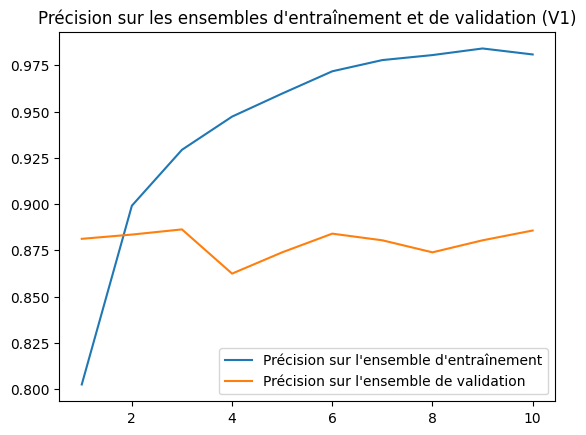

<Figure size 640x480 with 0 Axes>

In [228]:
accuracy_V1 = history_V1.history['accuracy']
val_accuracy_V1 = history_V1.history['val_accuracy']
loss_V1 = history_V1.history['loss']
val_loss_V1 = history_V1.history['val_loss']

steps=[i for i in range(1,11)]

plt.plot(steps, accuracy_V1, label="Précision sur l'ensemble d'entraînement")
plt.plot(steps, val_accuracy_V1, label="Précision sur l'ensemble de validation")
plt.title("Précision sur les ensembles d'entraînement et de validation (V1)")
plt.legend()

plt.figure()

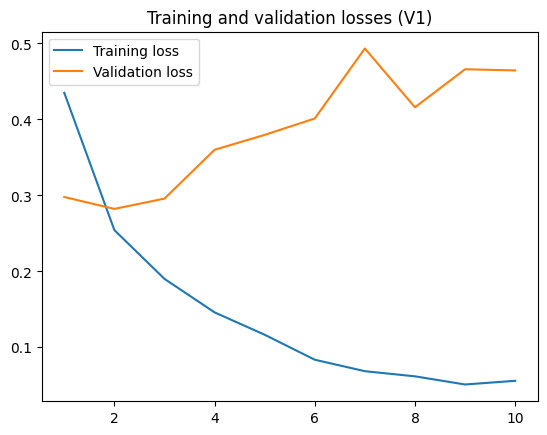

In [229]:
plt.plot(steps, loss_V1, label='Training loss')
plt.plot(steps, val_loss_V1, label='Validation loss')
plt.title('Training and validation losses (V1)')
plt.legend()
plt.show()

Avec quelques recherches, on apprend que les meilleures performances réalisées à ce jour sur l'ensemble IMDB est une accuracy de 96,2%. Par ailleurs, et plus simplement, on observe qu'au  bout de 2 epochs, les performances sur l'ensemble d'entraînement se stabilisent et n'augmentent plus. De même au bout de 2 epochs, on constate que les pertes réalisées sur l'ensemble de validation croissent alors que sur l'ensemble d'entraînement on arrive au bout de 10 epochs à une précision aberrante de 0.9809 et une perte de 0.0402 ce qui est bien trop optimiste pour notre modèle.

On est donc ici face à un cas d'**overfitting**.

Au bout de 2 epochs cependant, on obtient une validation accuracy de presque 89%, ce qui est mieux qu'avec notre régression logistique initiale. Cela est rassurant et nous laisse penser qu'en fine tunant un peu le modèle et en limitant l'overfitting, on pourra obtenir des résultats encore plus satisfaisants.

## Lutter contre l'overfitting
### Technique de dropout 

Afin de lutter contre l'overfitting, une technique usuelle dans le cas des réseaux de neurones est le **dropout**. Cette technique consiste à désactiver aléatoirement certains neurones à chaque itération de l'entraînement afin d'affaiblir certaines connexions très fortes qui résultent en de l'overfitting. Le réseau de neurones est alors dans l'obligation d'apprendre une représentation plus robuste des données ce qui devrait **limiter les risques de sur-apprentissage** et favoriser la **généralisation** à l'ensemble de test.

In [144]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model_V2 = Sequential()
model_V2.add(Embedding(input_dim=n_words, output_dim=dim_embedding, input_length=max_len)) #Transformation des indices en vecteurs
model_V2.add(SpatialDropout1D(0.2)) #Couche de Spatial Dropout : améliore la régularisation et prévient l'overfitting (désactive des canaux entiers de l'embedding) 
model_V2.add(LSTM(lstm_units)) #Couche LSTM
model_V2.add(Dropout(0.5)) #Couche de dropout classique
model_V2.add(Dense(1, activation='sigmoid')) #La fonction d'activation sigmoid est classique pour les problèmes de classification

#On compile le modèle 
model_V2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [145]:
history_V2 = model_V2.fit(X_train, Y_train, 
                    batch_size=32, 
                    epochs=10, 
                    validation_data=(X_val, Y_val))
test_loss_V2, test_acc_V2 = model_V2.evaluate(X_test, Y_test)
print('Test Accuracy:', test_acc_V2)

Epoch 1/10
938/938 [==============================] - 694s 736ms/step - loss: 0.4111 - accuracy: 0.8162 - val_loss: 0.3304 - val_accuracy: 0.8618
Epoch 2/10
938/938 [==============================] - 692s 737ms/step - loss: 0.2583 - accuracy: 0.9024 - val_loss: 0.3173 - val_accuracy: 0.8658
Epoch 3/10
938/938 [==============================] - 690s 736ms/step - loss: 0.1944 - accuracy: 0.9279 - val_loss: 0.2993 - val_accuracy: 0.8841
Epoch 4/10
938/938 [==============================] - 690s 736ms/step - loss: 0.2314 - accuracy: 0.9112 - val_loss: 0.3437 - val_accuracy: 0.8842
Epoch 5/10
938/938 [==============================] - 690s 736ms/step - loss: 0.1645 - accuracy: 0.9412 - val_loss: 0.3332 - val_accuracy: 0.8824
Epoch 6/10
938/938 [==============================] - 701s 748ms/step - loss: 0.1528 - accuracy: 0.9467 - val_loss: 0.3227 - val_accuracy: 0.8831
Epoch 7/10
938/938 [==============================] - 702s 748ms/step - loss: 0.0949 - accuracy: 0.9689 - val_loss: 0.3786 -

Nous obtenons une précision de **0.8825** sur l'ensemble de test ce qui est déjà très élevé et supérieur aux résultats obtenus avec des modèles plus simples que sont les **régressions logistiques** et le **Random Forest**. On remarque toutefois une précision trop importante sur l'ensemble d'entraînement puisque celle-ci atteint 98%.

In [164]:
accuracy_V2 = history_V2.history['accuracy']
val_accuracy_V2 = history_V2.history['val_accuracy']
loss_V2 = history_V2.history['loss']
val_loss_V2 = history_V2.history['val_loss']

steps=[i for i in range(1,11)]

<Figure size 640x480 with 0 Axes>

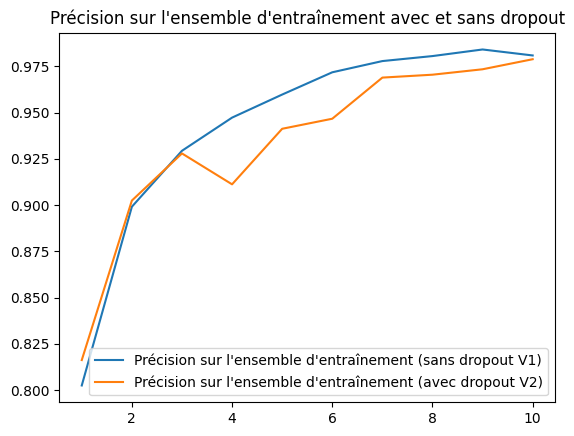

<Figure size 640x480 with 0 Axes>

In [241]:
plt.plot(steps, accuracy_V1, label="Précision sur l'ensemble d'entraînement (sans dropout V1)")
plt.plot(steps, accuracy_V2, label="Précision sur l'ensemble d'entraînement (avec dropout V2)")
plt.title("Précision sur l'ensemble d'entraînement avec et sans dropout")
plt.legend()

plt.figure()

On constate désormais que la courbe de précision sur l'ensemble d'entraînement connaît une **évolution moins linéaire** ce qui laisse penser que le dropout fait bien effet.

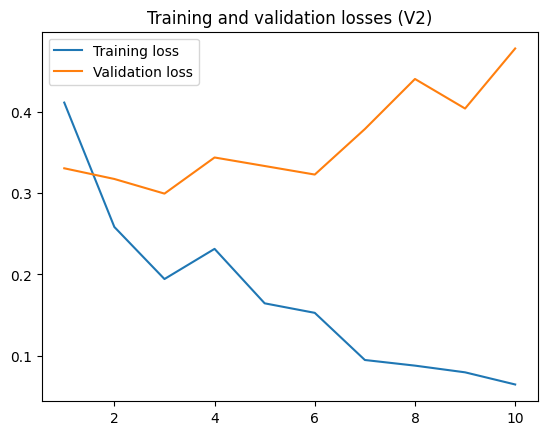

In [239]:
plt.plot(steps, loss_V2, label='Training loss')
plt.plot(steps, val_loss_V2, label='Validation loss')
plt.title('Training and validation losses (V2)')
plt.legend()
plt.show()

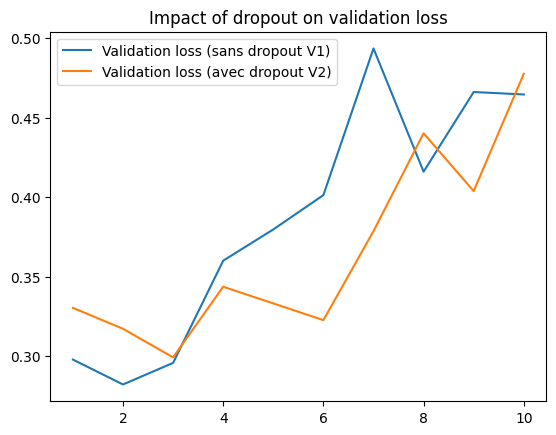

In [240]:
plt.plot(steps, val_loss_V1, label='Validation loss (sans dropout V1)')
plt.plot(steps, val_loss_V2, label='Validation loss (avec dropout V2)')
plt.title('Impact of dropout on validation loss')
plt.legend()
plt.show()

Ce graphe met en lumière l'effet positif du dropout sur les pertes enregistrées sur l'ensemble de validation : en moyenne, on observe une **perte inférieure sur cet ensemble** lorsque le dropout est intégré au modèle.

<Figure size 640x480 with 0 Axes>

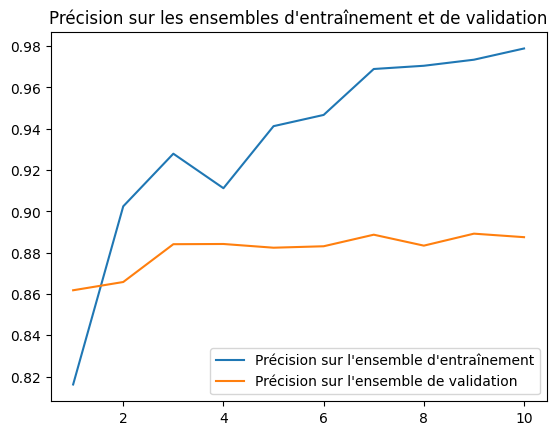

<Figure size 640x480 with 0 Axes>

In [165]:
plt.plot(steps, accuracy_V2, label="Précision sur l'ensemble d'entraînement")
plt.plot(steps, val_accuracy_V2, label="Précision sur l'ensemble de validation")
plt.title("Précision sur les ensembles d'entraînement et de validation")
plt.legend()

plt.figure()

Sur ce graphique représentant l'évolution des performances de notre modèle V2, on remarque qu'au bout de 3 epochs, la précision sur l'ensemble de validation se stabilise tandis que la précision sur l'ensemble d'entraînement commence à diverger. Nous pourrions donc très bien arrêter l'entraînement à ce moment là. C'est ce que nous allons faire en intégrant la technique dite de "**early stopping**".

### Early stopping

Le "**early stopping**" est une technique utilisée pour prévenir l'overfitting durant l'entraînement. Dès lors que les performances réalisées sur l'ensemble de validation ne s'améliore plus pendant un certain temps, l'entraînement est arrêté. Cela évite de continuer l'entraînement dans le vide.

In [148]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model_V3 = Sequential()
model_V3.add(Embedding(input_dim=n_words, output_dim=dim_embedding, input_length=max_len)) #Transformation des indices en vecteurs
model_V3.add(SpatialDropout1D(0.2))
model_V3.add(LSTM(lstm_units)) #Couche LSTM
model_V3.add(Dropout(0.5))
model_V3.add(Dense(1, activation='sigmoid')) #La fonction d'activation sigmoid est classique pour les problèmes de classification

#On compile le modèle 
model_V3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

On inclut l'early stopping en se concentrant sur la précision obtenue lors de l'entraînement sur l'ensemble de validation. Ici, si la précision de validation ne s'améliore pas d'au moins 10 % pendant deux "epochs" consécutives, on arrête l'entraînement du modèle avant qu'il n'arrive à son terme.

In [149]:
from tensorflow.keras.callbacks import EarlyStopping


early_stopping=EarlyStopping(monitor='val_accuracy', min_delta=0.1, patience=2, verbose=1)
history_V3 = model_V3.fit(X_train, Y_train, 
                    batch_size=32, 
                    epochs=10, 
                    validation_data=(X_val, Y_val),
                    callbacks=[early_stopping])
test_loss_V3, test_acc_V3 = model_V3.evaluate(X_test, Y_test)
print('Test Accuracy:', test_acc_V3)

Epoch 1/10
938/938 [==============================] - 695s 740ms/step - loss: 0.4029 - accuracy: 0.8161 - val_loss: 0.3041 - val_accuracy: 0.8794
Epoch 2/10
938/938 [==============================] - 694s 740ms/step - loss: 0.2956 - accuracy: 0.8830 - val_loss: 0.3138 - val_accuracy: 0.8820
Epoch 3/10
938/938 [==============================] - 693s 739ms/step - loss: 0.2101 - accuracy: 0.9221 - val_loss: 0.3112 - val_accuracy: 0.8806
Epoch 3: early stopping
313/313 [==============================] - 49s 156ms/step - loss: 0.3063 - accuracy: 0.8798
Test Accuracy: 0.879800021648407


Cette fois, l'entraînement s'est arrêté au bout de 3 epochs, ce qui correspond bien à ce que nous pouvions attendre après l'analyse du graphique précédent.

<Figure size 640x480 with 0 Axes>

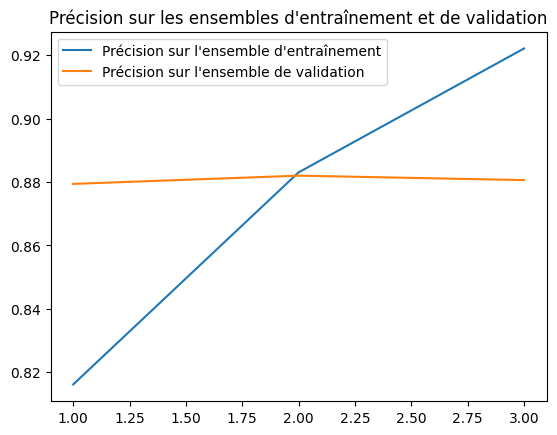

<Figure size 640x480 with 0 Axes>

In [150]:
accuracy_V3 = history_V3.history['accuracy']
val_accuracy_V3 = history_V3.history['val_accuracy']
loss_V3 = history_V3.history['loss']
val_loss_V3 = history_V3.history['val_loss']

steps=[i for i in range(1,len(accuracy_V3)+1)]

plt.plot(steps, accuracy_V3, label="Précision sur l'ensemble d'entraînement")
plt.plot(steps, val_accuracy_V3, label="Précision sur l'ensemble de validation")
plt.title("Précision sur les ensembles d'entraînement et de validation")
plt.legend()

plt.figure()

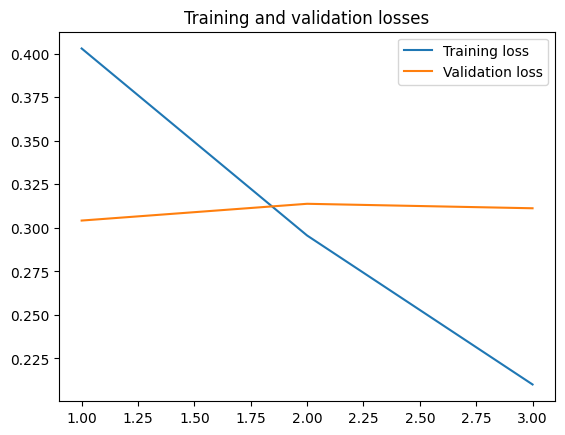

In [151]:
plt.plot(steps, loss_V3, label='Training loss')
plt.plot(steps, val_loss_V3, label='Validation loss')
plt.title('Training and validation losses')
plt.legend()
plt.show()

Dans ces deux graphiques, les courbes bleues commencent à diverger contrairement aux courbes oranges qui sont stables. Essayons de jouer sur d'autres paramètres pour prévenir ces risques d'overfitting.

### Fine tuning des paramètres

Ayant observé de l'overfitting, on va réduire le nombre de couches de LSTM afin d'éviter ce phénomène de surajustement. Il est usuel de considérer des puissances de 2, essayons avec 32 couches.

In [166]:
dim_embedding=128
lstm_units=32

model_V4 = Sequential()
model_V4.add(Embedding(input_dim=n_words, output_dim=dim_embedding, input_length=max_len)) #Transformation des indices en vecteurs
model_V4.add(SpatialDropout1D(0.2))
model_V4.add(LSTM(lstm_units)) #Couche LSTM
model_V4.add(Dropout(0.5))
model_V4.add(Dense(1, activation='sigmoid'))

model_V4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [167]:
early_stopping=EarlyStopping(monitor='val_accuracy', min_delta=0.1, patience=2, verbose=1)
history_V4 = model_V4.fit(X_train, Y_train, 
                    batch_size=32, 
                    epochs=10, 
                    validation_data=(X_val, Y_val))
test_loss_V4, test_acc_V4 = model_V4.evaluate(X_test, Y_test)
print('Test Accuracy:', test_acc_V4)

Epoch 1/10
938/938 [==============================] - 454s 483ms/step - loss: 0.4703 - accuracy: 0.7861 - val_loss: 0.3792 - val_accuracy: 0.8406
Epoch 2/10
938/938 [==============================] - 452s 482ms/step - loss: 0.2929 - accuracy: 0.8869 - val_loss: 0.2896 - val_accuracy: 0.8814
Epoch 3/10
938/938 [==============================] - 452s 482ms/step - loss: 0.2267 - accuracy: 0.9167 - val_loss: 0.2872 - val_accuracy: 0.8832
Epoch 4/10
938/938 [==============================] - 458s 488ms/step - loss: 0.1761 - accuracy: 0.9373 - val_loss: 0.3296 - val_accuracy: 0.8875
Epoch 5/10
938/938 [==============================] - 460s 490ms/step - loss: 0.1425 - accuracy: 0.9501 - val_loss: 0.3443 - val_accuracy: 0.8758
Epoch 6/10
938/938 [==============================] - 455s 485ms/step - loss: 0.1178 - accuracy: 0.9587 - val_loss: 0.3470 - val_accuracy: 0.8841
Epoch 7/10
938/938 [==============================] - 453s 483ms/step - loss: 0.0970 - accuracy: 0.9669 - val_loss: 0.3884 -

<Figure size 640x480 with 0 Axes>

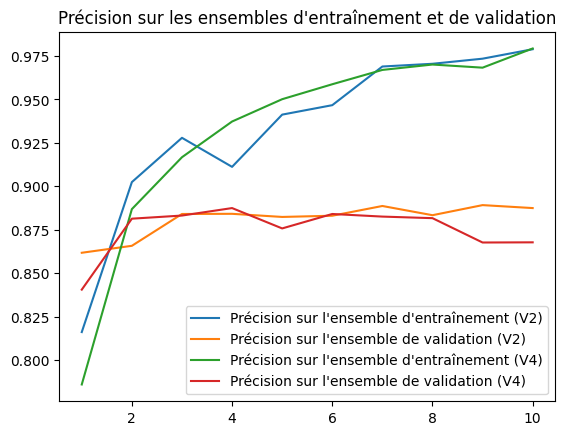

<Figure size 640x480 with 0 Axes>

In [193]:
accuracy_V4 = history_V4.history['accuracy']
val_accuracy_V4 = history_V4.history['val_accuracy']
loss_V4 = history_V4.history['loss']
val_loss_V4 = history_V4.history['val_loss']

steps=[i for i in range(1,len(accuracy_V4)+1)]


plt.plot(steps, accuracy_V2, label="Précision sur l'ensemble d'entraînement (V2)")
plt.plot(steps, val_accuracy_V2, label="Précision sur l'ensemble de validation (V2)")
plt.plot(steps, accuracy_V4, label="Précision sur l'ensemble d'entraînement (V4)")
plt.plot(steps, val_accuracy_V4, label="Précision sur l'ensemble de validation (V4)")
plt.title("Précision sur les ensembles d'entraînement et de validation")
plt.legend()

plt.figure()

La réduction du nombre d'unités LSTMs n'a **pas eu l'effet attendu** sur la réduction de l'overfitting. En effet, on constate que l'écart entre les performances sur les ensembles d'entraînement et de validation est plus grand en moyenne avec le modèle V4 par rapport au modèle V2.

Cela pourrait s'expliquer par **deux raisons** notamment :
- les données sont complexes et réduire le nombre d'unités LSTMs résulte en un modèle trop simple.
- le nombre d'unités choisi précédemment était peut-être déjà optimal et le modifier diminue la capacité de notre modèle à performer.

### Ajout d'une couche Dense

Testons l'apport d'une couche "**Dense**" supplémentaire au coeur du modèle. On attend de celle-ci qu'elle permette au modèle de capturer des relations plus complexes dans les données et donc qu'elle augmente la précision sur les ensembles de test et de validation.

In [170]:
model_V5 = Sequential()
model_V5.add(Embedding(input_dim=n_words, output_dim=dim_embedding, input_length=max_len))
model_V5.add(SpatialDropout1D(0.2))
model_V5.add(LSTM(lstm_units)) 
model_V5.add(Dense(units=20, activation='relu')) #Ajout de la nouvelle couche Dense. "ReLU" est une fonction d'activation classique qui permet de capturer de la non-linéarité dans les données et ainsi gagner en complexité
model_V5.add(Dropout(0.5))
model_V5.add(Dense(1, activation='sigmoid'))

model_V5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [171]:
early_stopping=EarlyStopping(monitor='val_accuracy', min_delta=0.1, patience=2, verbose=1)
history_V5 = model_V5.fit(X_train, Y_train, 
                    batch_size=32, 
                    epochs=10, 
                    validation_data=(X_val, Y_val))
test_loss_V5, test_acc_V5 = model_V5.evaluate(X_test, Y_test)
print('Test Accuracy:', test_acc_V5)

Epoch 1/10
938/938 [==============================] - 456s 485ms/step - loss: 0.5105 - accuracy: 0.7527 - val_loss: 0.5022 - val_accuracy: 0.7620
Epoch 2/10
938/938 [==============================] - 454s 485ms/step - loss: 0.3604 - accuracy: 0.8578 - val_loss: 0.3149 - val_accuracy: 0.8730
Epoch 3/10
938/938 [==============================] - 451s 481ms/step - loss: 0.2750 - accuracy: 0.9024 - val_loss: 0.4812 - val_accuracy: 0.7973
Epoch 4/10
938/938 [==============================] - 451s 481ms/step - loss: 0.2595 - accuracy: 0.9034 - val_loss: 0.3533 - val_accuracy: 0.8559
Epoch 5/10
938/938 [==============================] - 452s 482ms/step - loss: 0.1907 - accuracy: 0.9352 - val_loss: 0.3202 - val_accuracy: 0.8875
Epoch 6/10
938/938 [==============================] - 451s 481ms/step - loss: 0.1499 - accuracy: 0.9506 - val_loss: 0.3558 - val_accuracy: 0.8881
Epoch 7/10
938/938 [==============================] - 451s 480ms/step - loss: 0.1267 - accuracy: 0.9586 - val_loss: 0.3863 -

In [250]:
accuracy_V5 = history_V5.history['accuracy']
val_accuracy_V5 = history_V5.history['val_accuracy']
loss_V5 = history_V5.history['loss']
val_loss_V5 = history_V5.history['val_loss']

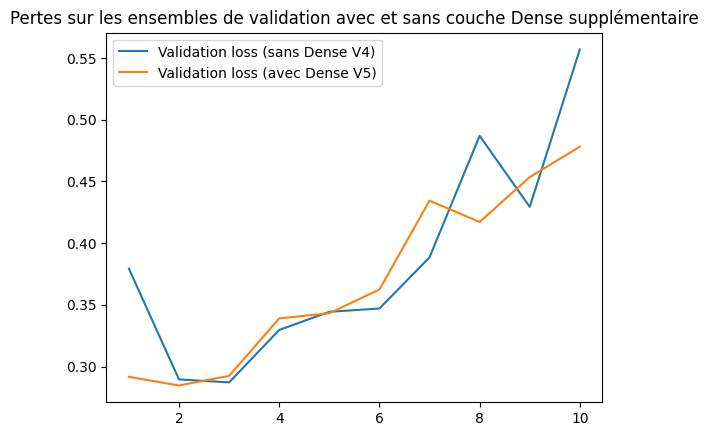

In [245]:
plt.plot(steps, val_loss_V4, label='Validation loss (sans Dense V4)')
plt.plot(steps, val_loss_V5, label='Validation loss (avec Dense V5)')
plt.title('Pertes sur les ensembles de validation avec et sans couche Dense supplémentaire')
plt.legend()
plt.show()

Ce graphique montre que l'ajout d'une couche Dense (modèle V5) a produit une **perte de validation légèrement inférieure** à celle du modèle sans cette couche supplémentaire (modèle V4), du moins lors des premières époques. Cependant, les deux courbes divergent vers la fin ce qui pourrait indiquer un sur-apprentissage. Cela suggère que la couche Dense supplémentaire a eu un effet bénéfique initial, mais que le modèle pourrait bénéficier de réglages supplémentaires pour maintenir et améliorer la généralisation sur l'ensemble de validation.

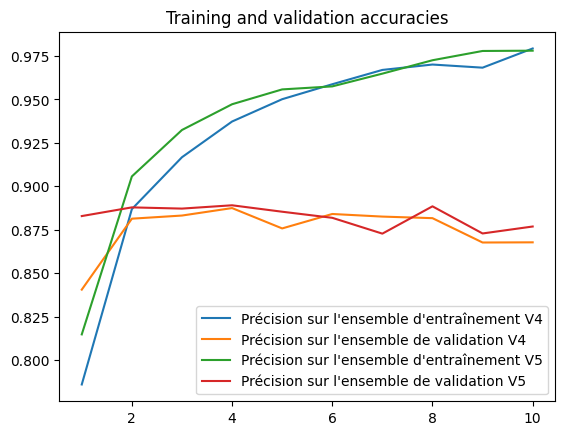

In [249]:

plt.plot(steps, accuracy_V4, label="Précision sur l'ensemble d'entraînement V4")
plt.plot(steps, val_accuracy_V4, label="Précision sur l'ensemble de validation V4")
plt.plot(steps, accuracy_V5, label="Précision sur l'ensemble d'entraînement V5")
plt.plot(steps, val_accuracy_V5, label="Précision sur l'ensemble de validation V5")
plt.title('Training and validation accuracies')
plt.legend()
plt.show()

L'écart important entre les courbes de précision sur les ensembles d'entraînement et de validation suggèrent un overfitting encore important. On constate tout de même que la précision sur l'ensemble de validation est légèement plus importante pour le modèle V5 avec la couche Dense supplémentaire par rapport au modèle V4 sans cette couche. Cela suggère un effet bénéfique de la couche ajoutée.

### Couche de LSTM bidirectionnelle

In [173]:
from keras.layers import Bidirectional

In [174]:
lstm_units=64
model_V6 = Sequential()
model_V6.add(Embedding(input_dim=n_words, output_dim=dim_embedding, input_length=max_len))
model_V6.add(SpatialDropout1D(0.2))
model_V6.add(Bidirectional(LSTM(lstm_units)))  
model_V6.add(Dense(units=64, activation='relu'))
model_V6.add(Dropout(0.5))
model_V6.add(Dense(1, activation='sigmoid'))

model_V6.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [175]:
early_stopping=EarlyStopping(monitor='val_accuracy', min_delta=0.1, patience=2, verbose=1)
history_V6 = model_V6.fit(X_train, Y_train, 
                    batch_size=32, 
                    epochs=10, 
                    validation_data=(X_val, Y_val))
test_loss_V6, test_acc_V6 = model_V6.evaluate(X_test, Y_test)
print('Test Accuracy:', test_acc_V6)

Epoch 1/10
938/938 [==============================] - 524s 557ms/step - loss: 0.4029 - accuracy: 0.8187 - val_loss: 0.2835 - val_accuracy: 0.8869
Epoch 2/10
938/938 [==============================] - 542s 577ms/step - loss: 0.2365 - accuracy: 0.9117 - val_loss: 0.2770 - val_accuracy: 0.8833
Epoch 3/10
938/938 [==============================] - 548s 584ms/step - loss: 0.1753 - accuracy: 0.9369 - val_loss: 0.2756 - val_accuracy: 0.8942
Epoch 4/10
938/938 [==============================] - 549s 585ms/step - loss: 0.1422 - accuracy: 0.9499 - val_loss: 0.3393 - val_accuracy: 0.8908
Epoch 5/10
938/938 [==============================] - 551s 587ms/step - loss: 0.1090 - accuracy: 0.9622 - val_loss: 0.4075 - val_accuracy: 0.8777
Epoch 6/10
938/938 [==============================] - 553s 589ms/step - loss: 0.0836 - accuracy: 0.9717 - val_loss: 0.4138 - val_accuracy: 0.8865
Epoch 7/10
938/938 [==============================] - 569s 606ms/step - loss: 0.0795 - accuracy: 0.9739 - val_loss: 0.4473 -

<Figure size 640x480 with 0 Axes>

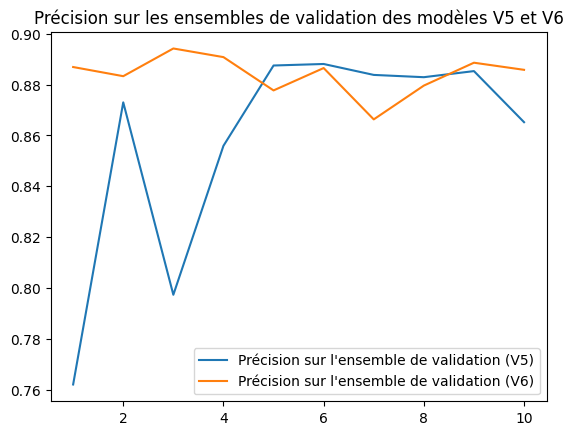

<Figure size 640x480 with 0 Axes>

In [252]:
accuracy_V6 = history_V6.history['accuracy']
val_accuracy_V6 = history_V6.history['val_accuracy']
loss_V6 = history_V6.history['loss']
val_loss_V6 = history_V6.history['val_loss']

steps=[i for i in range(1,len(accuracy_V6)+1)]

plt.plot(steps, val_accuracy_V5, label="Précision sur l'ensemble de validation (V5)")
plt.plot(steps, val_accuracy_V6, label="Précision sur l'ensemble de validation (V6)")
plt.title("Précision sur les ensembles de validation des modèles V5 et V6")
plt.legend()

plt.figure()

L'ajout de la couche de LSTM bidirectionnelle a permis de stabiliser les performances sur l'ensemble de validation pour obtenir une précision moyenne de 0.89, jamais atteinte avec nos modèles précédents. Ces résultats sont satisfaisants et nous confortent dans le fait que le modèle V6 est le plus performant que nous avons testé. Par rapport aux observations faites sur le modèle V5, on aurait pu continuer l'entraînement en essayant de réduire l'overfitting par l'augmentation du taux de dropout notamment ou en se concentrant sur la régularisation. On s'estime toutefois satisfaits de ces performances. 

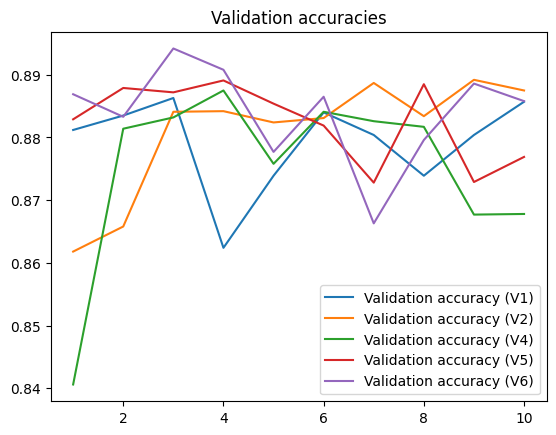

In [186]:
plt.plot(steps, val_accuracy_V1, label='Validation accuracy (V1)')
plt.plot(steps, val_accuracy_V2, label='Validation accuracy (V2)')
#plt.plot(steps, val_loss_V3, label='Validation loss (V3)')
plt.plot(steps, val_accuracy_V4, label='Validation accuracy (V4)')
plt.plot(steps, val_accuracy_V5, label='Validation accuracy (V5)')
plt.plot(steps, val_accuracy_V6, label='Validation accuracy (V6)')
plt.title('Validation accuracies')
plt.legend()
plt.show()

On l'observe encore mieux ici, le modèle V6 est le plus précis en moyenne sur les ensembles de validation. Nous allons le garder et l'enregistrer afin de le réutiliser plus tard.

In [190]:
model_V6.save('mon_modele_lstm.keras')